Cell segmentation

In [6]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

# Now import tensorflow/keras modules
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


To train our CNN we will use the segmentaiton images from 'BBBC005_v1_ground_truth' as our label data, 
and 'BBBC005_v1_images' as our feature data. 

Images that begin with 'F' have a segmentation counter part (there are 19200 total images and 1200 segmentation images). 

Thus, these 1200 images will be labeled and used for training.

In [13]:

import os
import csv
import deepchem as dc
import numpy as np 
# import re # Include if needed

image_dir = 'BBBC005_v1_images'
label_dir = 'BBBC005_v1_ground_truth'

rows = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
blurs = (1,4,7,10,14,17,20,23,26,29,32,35,39,42,45,48)
files = []
labels = []
paths_checked = 0

for f in os.listdir(label_dir):
    if f.endswith('.TIF') and '_F1' in f and '_A' in f: 
        for row, blur in zip(rows, blurs):
            fname = f.replace('_F1','_F%d'%blur).replace('_A','_%s'%row)
            image_path = os.path.join(image_dir, fname)
            paths_checked += 1
            
            if os.path.exists(image_path):
                files.append(image_path)
                labels.append(os.path.join(label_dir, f)) 

# --- IMPORTANT DEBUG OUTPUT ---
print(f"Total paths checked: {paths_checked}")
print(f"Files found and added: {len(files)}")

if paths_checked > 0 and len(files) == 0:
    print("\n--- DEBUGGING FILE NAMING ---")
    # Generate and print the last path checked (which failed)
    # Use the last variables from the loop for debugging context
    last_fname = f.replace('_F1','_F%d'%blur).replace('_A','_%s'%row)
    last_path = os.path.join(image_dir, last_fname)
    print(f"Example of generated path (failed): {last_path}")
    
    # List a file that *should* match to check directory paths
    print(f"List of files in image_dir (first 5): {os.listdir(image_dir)[:5]}")

    print("\nACTION: Check for typos, case sensitivity, or extra characters.")

# Create the dataset only if files were found
if len(files) > 0:
    dataset = dc.data.ImageDataset(files, labels)
    print(f"\nDataset created with {len(dataset)} samples.")
else:
    print("\nERROR: Cannot create dataset. No image files were found.")



Total paths checked: 19200
Files found and added: 19200

Dataset created with 19200 samples.


In [14]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, seed=123)

Because our outputs are images (segmentation masks), CNN Architecture won't work.
We need to use U-Net Architecture for image segmentation. 
U-Net Architecture stacks series of concolutions to progressivly downsample and then upsample the source image.

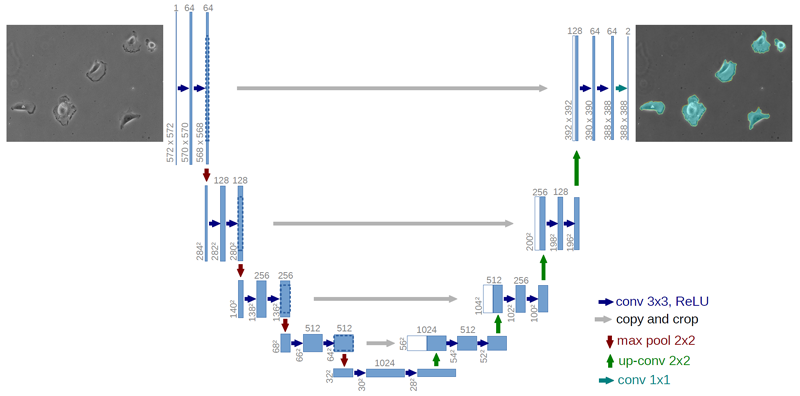

In [15]:
# Create the model.
features = tf.keras.Input(shape=(520, 696, 1))

# Downsample three times.
conv1 = layers.Conv2D(16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(features/255.0)
conv2 = layers.Conv2D(32, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(conv1)
conv3 = layers.Conv2D(64, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(conv2)

# Do a 1x1 convolution.
conv4 = layers.Conv2D(64, kernel_size=1, strides=1)(conv3)

# Upsample three times.
concat1 = layers.Concatenate(axis=3)([conv3, conv4])
deconv1 = layers.Conv2DTranspose(32, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(concat1)
concat2 = layers.Concatenate(axis=3)([conv2, deconv1])
deconv2 = layers.Conv2DTranspose(16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(concat2)
concat3 = layers.Concatenate(axis=3)([conv1, deconv2])
deconv3 = layers.Conv2DTranspose(1, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')(concat3)

# Compute the final output.
concat4 = layers.Concatenate(axis=3)([features, deconv3])
logits = layers.Conv2D(1, kernel_size=5, strides=1, padding='same')(concat4)
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])
learning_rate = dc.models.optimizers.ExponentialDecay(0.01, 0.9, 250)
seg_model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    learning_rate=learning_rate,
    seg_model_dir='models/segmentation')



In [ ]:
seg_model.fit(train_dataset, nb_epoch=100, checkpoint_interval=100)

In [16]:
scores = []
for x, y, w, id in test_dataset.itersamples():
  y_pred = seg_model.predict_on_batch([x]).squeeze()
  scores.append(np.mean((y>0) == (y_pred>0.5)))
print("Mean",np.mean(scores))

Mean 0.25126858145446507
